# indirectQ Example: Building a channel for indirect discharge calculations

In [1]:
from pathlib import Path
import os

import numpy as np
import matplotlib.pyplot as plt
from pyproj.crs.crs import CRS
import geopandas as gpd
import pandas as pd

import indirectQ as iq

The ```indirectQ``` package uses well documented 1-dimensional hydraulic calculations to indirectly estimate the stream discharge associated with a given water surface profile. To perform these calculations, a "channel" instance is created from three primary pieces of information:
1. A channel centerline for linear referencing.
2. Cross-sections (2 or more).
3. Channel roughness or flow resistance information in the form of Manning's n coefficients.

This example shows how to use the ```ChannelBuilder``` class to set up a stream channel for indirect discharge calculations. The ```ChannelBuilder``` instance is passed directly to the hydraulic calculation functions as it contains both the elevation and spatial information needed to set up and do the calculations.

### Paths to sample data
First, let's bring in some data to build our channel. Data can be loaded directly from surveyed profiles or extracted from underlying raster information.

In [2]:
topo_pth = Path("../sample_data/topo_raster/WFRC_lidar_20cm_EPSG32100.tif")
d_xsec_pth = Path("../sample_data/channel_shapefiles/WFRC_SAxsections_EPSG32100.shp")
chan_cnt_pth = Path("../sample_data/channel_shapefiles/WFRC_Chan_Centerline_EPSG32100.shp")
ws_pth = Path("../sample_data/HWM_points/West_Fork_Rock_Cr_20220628HWMs_EPSG32100.csv")
man_reg = Path("../sample_data/channel_shapefiles/Mannings_N_Regions.shp")

For 1D calculations, "profiles" are the central unit that a channel is made up of. These consist of longitudinal profile (centerline of stream bed elevations), cross-sectional profiles, and water surface profiles (a separate longitudinal profile that represents water surface elevation instead of stream bed elevations).

## Profiles
You can use this "base" unit, a Profile, as a stand alone entity. This is handled by the ```indirectQ.Profile``` class. Let's create one here using some of our sample data.

Currently indirectQ expects surveyed data used to create a Profile to be ordered (it does not reorder the surveyed points). Let's initialize a profile using the water surface profile data which is a file of surveyed points.

In [3]:
exm_p_data = pd.read_csv(ws_pth)
exm_p_data

,X,Y,Z,Name,CODE
0,2009591.854,328372.3469,6472.448635,062822_03,HWM-G
1,2009589.659,328371.1093,6472.932635,062822_04,HWM-G
2,2009585.576,328366.7142,6473.192635,062822_05,HWM-G
3,2009603.526,328350.1072,6472.952635,062822_07,HWM-G
4,2009612.433,328329.0052,6471.204635,062822_08,HWM-G
5,2009621.880,328312.6038,6471.512635,062822_09,HWM-G
6,2009565.877,328406.6413,6475.754635,062822_17,HWM-G
7,2009563.463,328406.6444,6476.195635,062822_18,HWM-G
8,2009642.458,328399.2748,6473.124635,062822_19,HWM-G
9,2009643.506,328399.9314,6473.431635,062822_20,HWM-G


In [5]:
tst_prof = iq.Profile.load_from_survey(exm_p_data, zcoord_name='Z', crs=6515)

In [4]:
arr, meta = iq.utilities.raster_array_from_file(topo_pth, data_scalar=(1/0.3048))

In [5]:
meta['crs'] = CRS.from_epsg(6515)

In [5]:
p = iq.Profile.extract_from_raster((arr, meta), chan_cnt_pth, profile_name='centerline')

In [6]:
cb = iq.ChannelBuilder(chan_cnt_pth, crs=6515, topo=(arr, meta))

In [7]:
xsecs = gpd.read_file(d_xsec_pth)

In [8]:
for i in range(len(xsecs)):
    cb.add_xsection(xsecs.loc[[i],:], invert_centerline=True)

In [21]:
cb.cross_sections

{0: {'Profile': <indirectQ.profile.Profile at 0x272dec2c210>,
  'Channel Rank': np.float64(1.0),
  'Xsec_Cntrln_Dist': np.float64(136.07594293083557),
  'WSE_Intersects': None,
  'Mean_WSE': None},
 1: {'Profile': <indirectQ.profile.Profile at 0x272dec2d450>,
  'Channel Rank': np.float64(2.0),
  'Xsec_Cntrln_Dist': np.float64(166.81241657140902),
  'WSE_Intersects': None,
  'Mean_WSE': None},
 2: {'Profile': <indirectQ.profile.Profile at 0x272decacad0>,
  'Channel Rank': np.float64(3.0),
  'Xsec_Cntrln_Dist': np.float64(264.89447456955867),
  'WSE_Intersects': None,
  'Mean_WSE': None},
 3: {'Profile': <indirectQ.profile.Profile at 0x272dec3bb50>,
  'Channel Rank': np.float64(4.0),
  'Xsec_Cntrln_Dist': np.float64(337.72366265823564),
  'WSE_Intersects': None,
  'Mean_WSE': None}}

In [9]:
cb.add_watersurface(exm_p_data, ws_zname='Z', reverse_centerline=True, ws_id='Flood')

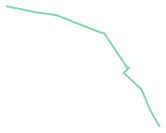

In [26]:
cb.water_profiles['Flood']['R']['Profile'].line

In [13]:
cb.cross_sections

{0: {'Profile': <indirectQ.profile.Profile at 0x12e87456510>,
  'Channel Rank': np.float64(1.0),
  'Xsec_Cntrln_Dist': np.float64(136.07594293083557),
  'WSE_Intersects': {'Flood': [[93.27707812103797, 6471.10036084881],
    [91.09686242938042, 6471.10036084881],
    [6.1195527323968495, 6471.10036084881],
    [114.25314349945323, 6471.10036084881]]},
  'Mean_WSE': {'Flood': np.float64(6471.10036084881)}},
 1: {'Profile': <indirectQ.profile.Profile at 0x12e8608cc10>,
  'Channel Rank': np.float64(2.0),
  'Xsec_Cntrln_Dist': np.float64(166.81241657140902),
  'WSE_Intersects': {'Flood': [[6.900121616866784, 6473.066223126169],
    [77.96109266542145, 6473.066223126169]]},
  'Mean_WSE': {'Flood': np.float64(6473.066223126169)}},
 2: {'Profile': <indirectQ.profile.Profile at 0x12e878af390>,
  'Channel Rank': np.float64(3.0),
  'Xsec_Cntrln_Dist': np.float64(264.89447456955867),
  'WSE_Intersects': {'Flood': [[17.20769494637663, 6477.345532539137],
    [95.81659387556952, 6477.345532539137]]

In [10]:
cb.mannings = {0: 0.04, 1: 0.06, 2: 0.06, 3: 0.07}

In [12]:
cb.mannings_by_distance(xs_id=1, dist_breakpoints=[40.0, 80.0], mannings_vals=[0.12, 0.05, 0.13])

In [15]:
cb.mannings

{0: array([0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
        0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
        0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
        0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
        0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
        0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
        0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
        0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
        0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
        0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
        0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
        0.04, 0.04, 0.04, 0.04, 0.04]),
 1: array([0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06,
        0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06

In [11]:
rdf, sup = iq.slopearea_q(cb)

C:\Users\cnb968\OneDrive - MT\GitHub\indirectQ\src\indirectQ\slopearea.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wsclp.loc[wsclp.index[-1]+1] = [p[0], p[1], np.nan]
C:\Users\cnb968\OneDrive - MT\GitHub\indirectQ\src\indirectQ\slopearea.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wsclp.loc[wsclp.index[-1]+1] = [p[0], p[1], np.nan]
C:\Users\cnb968\OneDrive - MT\GitHub\indirectQ\src\indirectQ\slopearea.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

TypeError: unhashable type: 'Series'

In [15]:
t = pd.DataFrame({'a': [1,3,4,5], 'b': [2,2,2,2]})

In [17]:
t.loc[t['a'] == 1]

,a,b
0,1,2


In [34]:
from scipy.integrate import trapezoid

ws_id = None
units = 'US'
if units == 'US':
    g = 32.17405
elif units == 'SI':
    g = 9.80665
else:
    print("Units not recognized...assume US.")
    g = 32.17405

if ws_id is not None:
    ws_id = [ws_id]
else:
    ws_id = list(cb.water_profiles.keys())

xsecs = cb.cross_sections
finQs = []
sup_results = {}
for ws in ws_id:
    xsec_cols = ['XSID', 'Rank', 'Area', 'K', 'alpha', 'mean_depth', 'Froude']
    xsec_df = []
    chnk_dfs = []
    for key, item in xsecs.items():
        xsdf = item['Profile'].points.loc[:, ['distance', 'elevation']]
        xsdf['mannings'] = cb.mannings[key]
        # clip cross section to WSE
        wsclp = xsdf.loc[xsdf['elevation'] <= item['Mean_WSE'][ws], :]
        # add intersect points
        for p in item['WSE_Intersects'][ws]:
            wsclp.loc[wsclp.index[-1]+1, 'distance'] = p[0]
            wsclp.loc[wsclp.index[-1], 'elevation'] = p[1]

        wsclp.sort_values(by='distance', inplace=True)
        wsclp.ffill(inplace=True)
        wsclp.bfill(inplace=True)
        wsclp['depth'] = item['Mean_WSE'][ws] - wsclp['elevation']
        bpoints = np.where(np.diff(wsclp['mannings'].values))[0] + 1
        if len(bpoints) == 0:
            wsclp['chunk'] = 'manning1'
        else:
            chnks = np.split(wsclp['mannings'].values, bpoints)
            ck_lst = []
            for i, c in enumerate(chnks):
                cname = [f'manning{i + 1}'] * c.size
                ck_lst.extend(cname)
            wsclp['chunk'] = ck_lst
        xsec_chnks = np.unique(wsclp['chunk'])

        chnk_cols = ['a', 'wp', 'r', 'K', 'K3/a2', 'n', '1.486/n']
        chnk_vals = []
        for chnk in xsec_chnks:
            xsr = wsclp.loc[wsclp['chunk'] == chnk]
            a = trapezoid(xsr['depth'], xsr['distance'])
            wp = iq.utilities.cumdistance_from_pnts(xsr['distance'].to_list(), xsr['depth'].to_list())[-1]
            if units == 'US':
                nc = 1.486 / xsr['mannings'].iloc[2]
            elif units == 'SI':
                nc = xsr['mannings'].iloc[2]
            else:
                print("Units not recognized...assume US.")
                nc = 1.486 / xsr['mannings'].iloc[2]
            r = (a / wp)**(2.0 / 3.0)
            K = nc * a * r
            Ka = K**3 / a**2
            chnk_vals.append([a, wp, r, K, Ka, xsr['mannings'].iloc[2], nc])

        chnkdf = pd.DataFrame(chnk_vals, columns=chnk_cols)
        chnkdf['crosssection'] = key
        chnkdf['K/Kt'] = chnkdf['K'] / chnkdf['K'].sum()

        chnk_dfs.append(chnkdf)

        xs_a = chnkdf['a'].sum()
        xs_K = chnkdf['K'].sum()
        xs_alpha = (chnkdf['K3/a2'].sum()) / (xs_K**3 / xs_a**2)
        xsecvals = [key, item['Channel Rank'], xs_a, xs_K, xs_alpha, wsclp['depth'].mean(), np.nan]
        xsec_df.append(xsecvals)

    chnk_df = pd.concat(chnk_dfs, ignore_index=True)
    xsecsdf = pd.DataFrame(xsec_df, columns=xsec_cols)

    rch_cols = ['Reach', 'Ks', 'Ke', 'As', 'Ae', 'alpha_s', 'alpha_e', 'k', 'Length', 'WSE_fall', 'Kw',
                'hvs', 'hve', 'delta_hv', 'hf', 'Sf^1/2', 'assumed_Q', 'calc_Q']
    rch_vals = []

    for rch in np.arange(1, len(xsecsdf)):
        s = rch
        e = rch + 1
        xss = xsecsdf.loc[xsecsdf['Rank'] == s].iloc[0]
        xse = xsecsdf.loc[xsecsdf['Rank'] == e].iloc[0]
        rlength = xsecs[xse['XSID']]['Xsec_Cntrln_Dist'] - xsecs[xss['XSID']]['Xsec_Cntrln_Dist']
        #K1 = [ranks[rch+xsec_dict1]]['XS_K']
        #K2 = xsec_dict[ranks[rch]]['XS_K']
        #A1 = xsec_dict[ranks[rch+1]]['XS_Area']
        #A2 = xsec_dict[ranks[rch]]['XS_Area']
        if xse['Area'] < xss['Area']:
            ki = 0.5
        else:
            ki = 1.0
        #alpha1 = xsec_dict[ranks[rch+1]]['XS_alpha']
        #alpha2 = xsec_dict[ranks[rch]]['XS_alpha']
        fall = xsecs[xse['XSID']]['Mean_WSE'][ws] - xsecs[xss['XSID']]['Mean_WSE'][ws]
        wght_K = np.sqrt(xse['K'] * xss['K'])
        #assmQ = K2 * np.sqrt((fall / ((K2/K1)*rlength + ((K2**2)/(2*g*(A2**2)))*(-alpha1*k*((A2/A1)**2)+(alpha2*k)))))
        assmq = xse['K'] * np.sqrt((fall / ((xse['K'] / xss['K']) * rlength + ((xse['K'] ** 2) /
                                                                                (2 * g * (xse['Area'] ** 2))) *
                                            (-xss['alpha'] * (1 - ki) * ((xse['Area'] / xss['Area']) ** 2) +
                                                (xse['alpha'] * (1 - ki))))))
        ve = assmq / xse['Area']
        xsecsdf.loc[xsecsdf['XSID'] == xse['XSID'], 'Froude'] = ve / np.sqrt(
            g * xsecsdf.loc[xsecsdf['XSID'] == xse['XSID'], 'mean_depth'])
        vs = assmq / xss['Area']
        xsecsdf.loc[xsecsdf['XSID'] == xss['XSID'],'Froude'] = vs / np.sqrt(
            g*xsecsdf.loc[xsecsdf['XSID'] == xss['XSID'], 'mean_depth'])
        hve = xse['alpha'] * ((ve**2) / (2 * g))
        hvs = xss['alpha'] * ((vs**2) / (2 * g))
        del_hv = hve - hvs
        if del_hv >= 0:
            hf = fall + (del_hv * 0.5)
            k = 0.5
        else:
            hf = fall + del_hv
            k = 0.0
        sf = hf / rlength
        sf_sqrt = np.sqrt(sf)
        compq = wght_K * sf_sqrt
        rch_vals.append([rch, xss['K'], xse['K'], xss['Area'], xse['Area'], xss['alpha'], xse['alpha'], k,
                            rlength, fall, wght_K, hvs, hve, del_hv, hf, sf_sqrt, assmq, compq])

    rchdf = pd.DataFrame(rch_vals, columns=rch_cols)

C:\Users\cnb968\AppData\Local\Temp\ipykernel_23956\3852115326.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wsclp.loc[wsclp.index[-1]+1, 'distance'] = p[0]
C:\Users\cnb968\AppData\Local\Temp\ipykernel_23956\3852115326.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wsclp.loc[wsclp.index[-1]+1, 'distance'] = p[0]
C:\Users\cnb968\AppData\Local\Temp\ipykernel_23956\3852115326.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
chnk_df

,a,wp,r,K,K3/a2,n,1.486/n,crosssection,K/Kt
0,270.003919,116.569870,1.750609,17559.739000,7.427010e+07,0.04,37.150000,0,1.0
1,300.025157,76.119336,2.495218,18541.022709,7.080855e+07,0.06,24.766667,1,1.0
2,361.157502,85.843603,2.606108,23310.772585,9.711285e+07,0.06,24.766667,2,1.0
3,405.052502,117.426693,2.282950,19630.366755,4.610655e+07,0.07,21.228571,3,1.0


In [36]:
xsecsdf

,XSID,Rank,Area,K,alpha,mean_depth,Froude
0,0,1.0,270.003919,17559.739000,1.0,2.455438,1.901463
1,1,2.0,300.025157,18541.022709,1.0,4.110214,1.258620
2,2,3.0,361.157502,23310.772585,1.0,4.515703,1.010730
3,3,4.0,405.052502,19630.366755,1.0,3.617267,1.006915


In [35]:
rchdf

,Reach,Ks,Ke,As,Ae,alpha_s,alpha_e,k,Length,WSE_fall,Kw,hvs,hve,delta_hv,hf,Sf^1/2,assumed_Q,calc_Q
0,1,17559.739000,18541.022709,270.003919,300.025157,1.0,1.0,0.0,30.736474,1.965862,18043.711358,4.438896,3.595007,-0.843889,1.121974,0.191058,4563.261908,3447.387939
1,2,18541.022709,23310.772585,300.025157,361.157502,1.0,1.0,0.0,98.082058,4.279309,20789.554201,3.255543,2.246702,-1.008841,3.270469,0.182604,4342.474094,3796.255075
2,3,23310.772585,19630.366755,361.157502,405.052502,1.0,1.0,0.0,72.829188,3.081165,21391.564113,2.306564,1.833733,-0.472831,2.608334,0.189247,4399.945045,4048.287889


In [30]:
xss = xsecsdf.loc[xsecsdf['Rank'] == s].iloc[0]

In [32]:
xss["XSID"]

np.float64(0.0)

In [22]:
chnk_df

,a,wp,r,K,K3/a2,n,1.486/n,crosssection,K/Kt
0,270.003919,116.569870,1.750609,17559.739000,7.427010e+07,0.04,37.150000,0,1.0
1,300.025157,76.119336,2.495218,18541.022709,7.080855e+07,0.06,24.766667,1,1.0
2,361.157502,85.843603,2.606108,23310.772585,9.711285e+07,0.06,24.766667,2,1.0
3,405.052502,117.426693,2.282950,19630.366755,4.610655e+07,0.07,21.228571,3,1.0


In [41]:
idx = np.where(np.diff(t))[0] + 1

In [44]:
chnks = np.split(t, idx)

In [48]:
tdf = pd.DataFrame()

In [51]:
cks = []
for i, c in enumerate(chnks):
    k = [f'manning{i+1}'] * c.size
    cks.extend(k)

In [53]:
tdf['chunks'] = cks

In [55]:
tdf['mannings'] = t

In [56]:
tdf

,chunks,mannings
0,manning1,0.12
1,manning1,0.12
2,manning1,0.12
3,manning1,0.12
4,manning1,0.12
...,...,...
97,manning3,0.13
98,manning3,0.13
99,manning3,0.13
100,manning3,0.13


In [46]:
len(['y'] * chnks[0].size)

41

In [19]:
ws = gpd.read_file(ws_pth)

In [29]:
isinstance(ws, gpd.GeoDataFrame)

False

In [33]:
if (isinstance(ws, pd.DataFrame)) & (not isinstance(ws, gpd.GeoDataFrame)):
    print('Yes')
else:
    print('Not Both')

Yes


In [17]:
chan = gpd.read_file(chan_cnt_pth)

In [28]:
isinstance(chan, gpd.GeoDataFrame)

True

In [18]:
chan.active_geometry_name

'geometry'

In [22]:
b

BoundingBox(left=2009252.8016979918, bottom=328148.5196213169, right=2009905.6016979916, top=328653.9196213182)

In [19]:
met['transform']

Affine(0.19999999999994295, 0.0, 2009252.8016979918,
       0.0, -0.20000000000049292, 328653.9196213182)

In [30]:
met['transform'].column_vectors

((0.19999999999994295, 0.0),
 (0.0, -0.20000000000049292),
 (2009252.8016979918, 328653.9196213182))

In [12]:
chan.columns.to_list()

['Id', 'geometry']

In [18]:
t = pd.DataFrame({'A': [1,2,3,4], 'B': ['c', 'b', 'd', 'e'], 'C': [1,1,1,1]})

In [26]:
t.iloc[0, :][[True, True, False]].index.to_list()

['A', 'B']

In [10]:
shp_ln = chan.geometry[0]

In [11]:
gpd.GeoDataFrame(geometry=[shp_ln])

,geometry
0,"LINESTRING (2009433.723 328519.526, 2009463.58..."


In [32]:
from pyproj.crs.crs import CRS
CRS.from_wkt(met['crs'].to_wkt())

<Engineering CRS: LOCAL_CS["NAD_1983_2011_StatePlane_Montana_FIPS_25 ...>
Name: NAD_1983_2011_StatePlane_Montana_FIPS_2500_Ft_Intl
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Datum: Unknown engineering datum
- Ellipsoid: undefined
- Prime Meridian: undefined

In [3]:
ws = pd.read_csv(ws_pth)

In [4]:
ws

,X,Y,Z,Name,CODE
0,2009591.854,328372.3469,6472.448635,062822_03,HWM-G
1,2009589.659,328371.1093,6472.932635,062822_04,HWM-G
2,2009585.576,328366.7142,6473.192635,062822_05,HWM-G
3,2009603.526,328350.1072,6472.952635,062822_07,HWM-G
4,2009612.433,328329.0052,6471.204635,062822_08,HWM-G
5,2009621.880,328312.6038,6471.512635,062822_09,HWM-G
6,2009565.877,328406.6413,6475.754635,062822_17,HWM-G
7,2009563.463,328406.6444,6476.195635,062822_18,HWM-G
8,2009642.458,328399.2748,6473.124635,062822_19,HWM-G
9,2009643.506,328399.9314,6473.431635,062822_20,HWM-G


In [6]:
pnts = gpd.points_from_xy(ws['X'], ws['Y'], crs=6515)

In [19]:
gdf = gpd.GeoDataFrame(geometry=pnts, crs=6515)

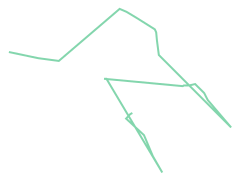

In [23]:
LineString(gdf.geometry.values)

In [15]:
d = {'a': 1, 'b': 2, 0: 3}

In [16]:
tmp_id = 0
while tmp_id in list(d.keys()):
    tmp_id += 1

In [18]:
t = pd.DataFrame({'A':[1,2,3,4,5], 'B':['r', 'r', 'r', 'l', 'l']})

In [26]:
t.loc[t['B'] == 'n'].sort_values(by='A')

,A,B


In [16]:
from pyproj.crs.crs import CRS
CRS.from_epsg(6515)

<Projected CRS: EPSG:6515>
Name: NAD83(2011) / Montana (ft)
Axis Info [cartesian]:
- X[east]: Easting (foot)
- Y[north]: Northing (foot)
Area of Use:
- name: United States (USA) - Montana - counties of Beaverhead; Big Horn; Blaine; Broadwater; Carbon; Carter; Cascade; Chouteau; Custer; Daniels; Dawson; Deer Lodge; Fallon; Fergus; Flathead; Gallatin; Garfield; Glacier; Golden Valley; Granite; Hill; Jefferson; Judith Basin; Lake; Lewis and Clark; Liberty; Lincoln; Madison; McCone; Meagher; Mineral; Missoula; Musselshell; Park; Petroleum; Phillips; Pondera; Powder River; Powell; Prairie; Ravalli; Richland; Roosevelt; Rosebud; Sanders; Sheridan; Silver Bow; Stillwater; Sweet Grass; Teton; Toole; Treasure; Valley; Wheatland; Wibaux; Yellowstone.
- bounds: (-116.07, 44.35, -104.04, 49.01)
Coordinate Operation:
- name: SPCS83 Montana zone (international foot)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: G

In [36]:
h, w = arr.shape
cols, rows = np.meshgrid(np.arange(w), np.arange(h))

In [37]:
xs, ys = rio.transform.xy(met['transform'], rows, cols)

In [56]:
topo = np.stack((np.reshape(xs, arr.shape), np.reshape(ys, arr.shape), arr), axis=0)

In [61]:
met['nodata']

-3.4028234663852886e+38

In [63]:
nodat = np.where(arr == met['nodata'],np.nan, arr)

In [65]:
import matplotlib.pyplot as plt

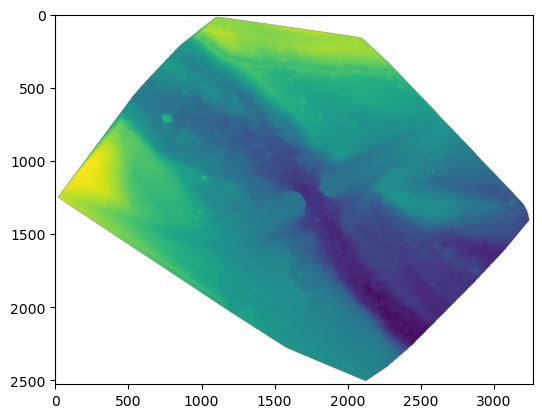

In [66]:
plt.imshow(nodat)

In [60]:
topo[2,:,:]

array([[-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
        -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
       [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
        -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
       [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
        -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
       ...,
       [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
        -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
       [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
        -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
       [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
        -3.40282347e+38, -3.40282347e+38, -3.40282347e+38]],
      shape=(2527, 3264))

In [46]:
ws['X'].values

array([2009591.854, 2009589.659, 2009585.576, 2009603.526, 2009612.433,
       2009621.88 , 2009565.877, 2009563.463, 2009642.458, 2009643.506,
       2009648.937, 2009654.837, 2009663.954, 2009667.446, 2009690.967,
       2009618.438, 2009616.525, 2009615.775, 2009614.436, 2009595.873,
       2009585.956, 2009579.118, 2009518.06 , 2009497.484, 2009467.971])

In [48]:
rc = rio.transform.rowcol(met['transform'], ws['X'].values, ws['Y'].values)

In [53]:
1 / 0.3048

3.280839895013123

In [52]:
arr[rc] / 0.3048

array([6470.0645, 6470.4565, 6471.511 , 6474.474 , 6470.836 , 6470.4976,
       6478.1924, 6477.1147, 6471.662 , 6471.921 , 6472.231 , 6472.657 ,
       6472.692 , 6473.25  , 6471.714 , 6477.436 , 6474.9663, 6475.947 ,
       6477.0923, 6476.8604, 6476.132 , 6477.013 , 6477.5664, 6480.0356,
       6482.4585], dtype=float32)

In [68]:
d = {0: 'Yes'}

In [71]:
met

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 3264,
 'height': 2527,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["NAD_1983_2011_StatePlane_Montana_FIPS_2500_Ft_Intl",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(0.19999999999994295, 0.0, 2009252.8016979918,
        0.0, -0.20000000000049292, 328653.9196213182)}

In [3]:
channel = iq.LoadSurvey(chan_cnt_pth, ws_pth, ws_x='X', ws_y='Y', ws_crs="EPSG:6515", topo_pth=topo_pth)

ValueError: all input arrays must have the same shape

In [6]:
channel.extractXsections(d_xsec_pth)
channel.assign_wse()

In [11]:
channel.extracted_xsections

{'0': {'lineID': 0,
  'Line': <LINESTRING (2009608.647 328322.667, 2009720.27 328376.91)>,
  'Points':      Dwnstrm_Distance                        geometry        value
  0            0.000000  POINT (2009608.647 328322.667)  6472.982972
  1            1.000000  POINT (2009609.547 328323.104)  6472.864426
  2            2.000000  POINT (2009610.446 328323.541)  6472.638949
  3            3.000000  POINT (2009611.346 328323.978)  6472.285313
  4            4.000000  POINT (2009612.245 328324.415)  6471.986545
  ..                ...                             ...          ...
  121        121.000000  POINT (2009717.478 328375.553)  6473.019818
  122        122.000000   POINT (2009718.377 328375.99)  6473.796774
  123        123.000000  POINT (2009719.277 328376.427)  6474.949394
  124        124.000000  POINT (2009720.176 328376.865)  6475.327459
  125        124.104364    POINT (2009720.27 328376.91)  6475.179677
  
  [126 rows x 3 columns],
  'Channel Rank': 1,
  'Xsec_Cntrln_Dist':

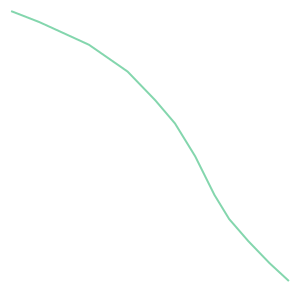

In [14]:
channel.channel_centerline['0']['Line']

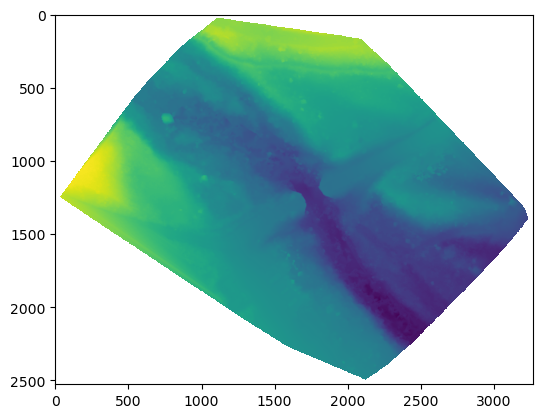

In [16]:
nantopo = np.where(channel.terrain[2] < 0, np.nan, channel.terrain[2])
plt.imshow(nantopo)

In [31]:
channel.extracted_xsections['2']

{'lineID': 2,
 'Line': <LINESTRING (2009523.778 328405.269, 2009601.173 328471.71)>,
 'Points':      Dwnstrm_Distance                        geometry        value
 0            0.000000  POINT (2009523.778 328405.269)  6478.561441
 1            1.000000   POINT (2009524.537 328405.92)  6478.368003
 2            2.000000  POINT (2009525.296 328406.572)  6478.542218
 3            3.000000  POINT (2009526.055 328407.223)  6478.412858
 4            4.000000  POINT (2009526.813 328407.874)  6478.480942
 ..                ...                             ...          ...
 99          99.000000  POINT (2009598.895 328469.755)  6478.629926
 100        100.000000  POINT (2009599.654 328470.406)  6478.907067
 101        101.000000  POINT (2009600.413 328471.057)  6479.545453
 102        102.000000  POINT (2009601.172 328471.709)  6480.384086
 103        102.001709   POINT (2009601.173 328471.71)  6480.384086
 
 [104 rows x 3 columns],
 'Channel Rank': 3,
 'Xsec_Cntrln_Dist': 156.0715310072682}

In [20]:
import numpy as np
channel.terrain[2]
nt = np.where(channel.terrain[2] < 0, np.nan, channel.terrain[2])

In [25]:
channel.channel_centerline['0']['Points']

,Dwnstrm_Distance,geometry,value
0,0.000000,POINT (2009433.723 328519.526),6478.223425
1,1.000000,POINT (2009434.655 328519.164),6477.879802
2,2.000000,POINT (2009435.587 328518.801),6477.652722
3,3.000000,POINT (2009436.519 328518.438),6477.653924
4,4.000000,POINT (2009437.451 328518.075),6477.656327
...,...,...,...
417,417.000000,POINT (2009724.383 328236.938),6460.817993
418,418.000000,POINT (2009725.118 328236.26),6460.963772
419,419.000000,POINT (2009725.853 328235.582),6461.364266
420,420.000000,POINT (2009726.588 328234.904),6461.682658


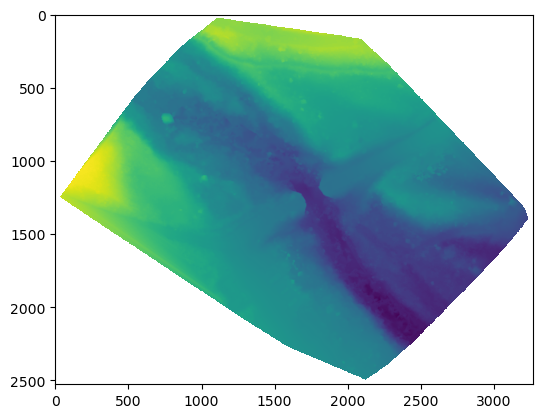

In [22]:
import matplotlib.pyplot as plt
plt.imshow(nt)